# Method 9 - Best Ideas Medium Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
best_ideas = best_ideas[(best_ideas['size_pct'] > (1 / 3)) & (best_ideas['size_pct'] < (2 / 3))]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

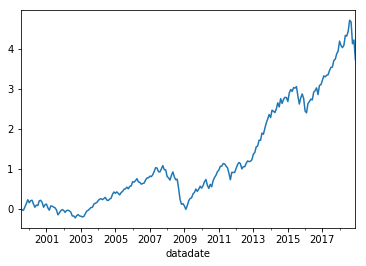

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.230864
2000-12-31   -0.099792
2001-12-31   -0.111480
2002-12-31   -0.159183
2003-12-31    0.403332
2004-12-31    0.225570
2005-12-31    0.106182
2006-12-31    0.128765
2007-12-31    0.112413
2008-12-31   -0.426819
2009-12-31    0.383692
2010-12-31    0.231128
2011-12-31   -0.008601
2012-12-31    0.164662
2013-12-31    0.506112
2014-12-31    0.125637
2015-12-31   -0.005178
2016-12-31    0.090408
2017-12-31    0.205356
2018-12-31   -0.043803
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     633.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.56e-122
Time:                        20:43:56   Log-Likelihood:                 674.93
No. Observations:                 234   AIC:                            -1340.
Df Residuals:                     229   BIC:                            -1323.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.882      0.004       0.001       0.005
mktrf          0.9865      0.025     38.690      0.000       0.936       1.037
me             0.2549      0.030      8.592      0.000       0.196       0.313
ia            -0.0661      0.045     -1.466      0.144      -0.155       0.023
roe            0.0794      0.039      2.058      0.041       0.003       0.155
==============================================================================
Omnibus:                       16.465   Durbin-Watson:                   1.810
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.568
Skew:                           0.225   Prob(JB):                     9.41e-10
Kurtosis:                       5.015   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     636.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.30e-123
Time:                        20:43:56   Log-Likelihood:                 674.93
No. Observations:                 234   AIC:                            -1340.
Df Residuals:                     229   BIC:                            -1323.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.489      0.000       0.001       0.004
mktrf          0.9865      0.037     26.582      0.000       0.914       1.059
me             0.2549      0.053      4.818      0.000       0.151       0.359
ia            -0.0661      0.073     -0.909      0.363      -0.208       0.076
roe            0.0794      0.043      1.832      0.067      -0.006       0.164
==============================================================================
Omnibus:                       16.465   Durbin-Watson:                   1.810
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.568
Skew:                           0.225   Prob(JB):                     9.41e-10
Kurtosis:                       5.015   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     820.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.91e-134
Time:                        20:43:56   Log-Likelihood:                 674.93
No. Observations:                 234   AIC:                            -1340.
Df Residuals:                     229   BIC:                            -1323.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.711      0.000       0.001       0.004
mktrf          0.9865      0.040     24.825      0.000       0.909       1.064
me             0.2549      0.051      4.981      0.000       0.155       0.355
ia            -0.0661      0.076     -0.865      0.387      -0.216       0.084
roe            0.0794      0.042      1.906      0.057      -0.002       0.161
==============================================================================
Omnibus:                       16.465   Durbin-Watson:                   1.810
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.568
Skew:                           0.225   Prob(JB):                     9.41e-10
Kurtosis:                       5.015   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     471.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.67e-118
Time:                        20:43:56   Log-Likelihood:                 667.71
No. Observations:                 234   AIC:                            -1323.
Df Residuals:                     228   BIC:                            -1303.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.753      0.006       0.001       0.005
mktrf          0.9825      0.026     37.208      0.000       0.930       1.035
smb            0.2782      0.035      7.986      0.000       0.210       0.347
hml           -0.0657      0.041     -1.598      0.111      -0.147       0.015
rmw            0.0677      0.046      1.457      0.146      -0.024       0.159
cma           -0.0120      0.059     -0.203      0.839      -0.128       0.104
==============================================================================
Omnibus:                       22.679   Durbin-Watson:                   1.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.836
Skew:                           0.388   Prob(JB):                     1.67e-13
Kurtosis:                       5.330   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     791.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.01e-142
Time:                        20:43:56   Log-Likelihood:                 667.71
No. Observations:                 234   AIC:                            -1323.
Df Residuals:                     228   BIC:                            -1303.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.793      0.005       0.001       0.005
mktrf          0.9825      0.039     25.479      0.000       0.907       1.058
smb            0.2782      0.053      5.245      0.000       0.174       0.382
hml           -0.0657      0.064     -1.020      0.308      -0.192       0.061
rmw            0.0677      0.053      1.268      0.205      -0.037       0.172
cma           -0.0120      0.105     -0.114      0.909      -0.217       0.193
==============================================================================
Omnibus:                       22.679   Durbin-Watson:                   1.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.836
Skew:                           0.388   Prob(JB):                     1.67e-13
Kurtosis:                       5.330   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     1018.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.00e-153
Time:                        20:43:56   Log-Likelihood:                 667.71
No. Observations:                 234   AIC:                            -1323.
Df Residuals:                     228   BIC:                            -1303.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.857      0.004       0.001       0.005
mktrf          0.9825      0.041     23.954      0.000       0.902       1.063
smb            0.2782      0.059      4.677      0.000       0.162       0.395
hml           -0.0657      0.068     -0.965      0.334      -0.199       0.068
rmw            0.0677      0.050      1.343      0.179      -0.031       0.167
cma           -0.0120      0.107     -0.112      0.911      -0.221       0.197
==============================================================================
Omnibus:                       22.679   Durbin-Watson:                   1.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.836
Skew:                           0.388   Prob(JB):                     1.67e-13
Kurtosis:                       5.330   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     609.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.46e-121
Time:                        20:43:56   Log-Likelihood:                 670.73
No. Observations:                 234   AIC:                            -1331.
Df Residuals:                     229   BIC:                            -1314.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      2.812      0.005       0.001       0.004
mktrf          1.0081      0.024     42.176      0.000       0.961       1.055
smb            0.2039      0.030      6.833      0.000       0.145       0.263
hml            0.0174      0.030      0.586      0.559      -0.041       0.076
umd            0.0771      0.019      3.964      0.000       0.039       0.115
==============================================================================
Omnibus:                       18.458   Durbin-Watson:                   1.716
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.358
Skew:                           0.301   Prob(JB):                     1.41e-10
Kurtosis:                       5.071   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     708.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.13e-127
Time:                        20:43:56   Log-Likelihood:                 670.73
No. Observations:                 234   AIC:                            -1331.
Df Residuals:                     229   BIC:                            -1314.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      2.947      0.003       0.001       0.004
mktrf          1.0081      0.032     31.211      0.000       0.945       1.071
smb            0.2039      0.063      3.235      0.001       0.080       0.327
hml            0.0174      0.057      0.306      0.759      -0.094       0.128
umd            0.0771      0.030      2.578      0.010       0.018       0.136
==============================================================================
Omnibus:                       18.458   Durbin-Watson:                   1.716
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.358
Skew:                           0.301   Prob(JB):                     1.41e-10
Kurtosis:                       5.071   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     949.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.81e-141
Time:                        20:43:57   Log-Likelihood:                 670.73
No. Observations:                 234   AIC:                            -1331.
Df Residuals:                     229   BIC:                            -1314.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.158      0.002       0.001       0.004
mktrf          1.0081      0.033     30.586      0.000       0.943       1.073
smb            0.2039      0.070      2.895      0.004       0.066       0.342
hml            0.0174      0.055      0.314      0.754      -0.091       0.126
umd            0.0771      0.023      3.369      0.001       0.032       0.122
==============================================================================
Omnibus:                       18.458   Durbin-Watson:                   1.716
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.358
Skew:                           0.301   Prob(JB):                     1.41e-10
Kurtosis:                       5.071   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     278.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.69e-58
Time:                        20:43:57   Log-Likelihood:                 325.23
No. Observations:                 120   AIC:                            -640.5
Df Residuals:                     115   BIC:                            -626.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.002      1.927      0.056   -8.42e-05       0.006
mktrf          1.0493      0.042     24.760      0.000       0.965       1.133
me             0.2339      0.042      5.587      0.000       0.151       0.317
ia            -0.0348      0.066     -0.532      0.596      -0.165       0.095
roe            0.1590      0.058      2.740      0.007       0.044       0.274
==============================================================================
Omnibus:                        6.749   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                7.987
Skew:                           0.332   Prob(JB):                       0.0184
Kurtosis:                       4.076   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     333.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.92e-62
Time:                        20:43:57   Log-Likelihood:                 325.23
No. Observations:                 120   AIC:                            -640.5
Df Residuals:                     115   BIC:                            -626.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      2.898      0.004       0.001       0.005
mktrf          1.0493      0.051     20.526      0.000       0.949       1.149
me             0.2339      0.052      4.533      0.000       0.133       0.335
ia            -0.0348      0.086     -0.405      0.686      -0.204       0.134
roe            0.1590      0.051      3.093      0.002       0.058       0.260
==============================================================================
Omnibus:                        6.749   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                7.987
Skew:                           0.332   Prob(JB):                       0.0184
Kurtosis:                       4.076   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     657.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.34e-78
Time:                        20:43:57   Log-Likelihood:                 325.23
No. Observations:                 120   AIC:                            -640.5
Df Residuals:                     115   BIC:                            -626.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.769      0.000       0.001       0.005
mktrf          1.0493      0.046     22.836      0.000       0.959       1.139
me             0.2339      0.051      4.625      0.000       0.135       0.333
ia            -0.0348      0.086     -0.405      0.686      -0.204       0.134
roe            0.1590      0.034      4.672      0.000       0.092       0.226
==============================================================================
Omnibus:                        6.749   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                7.987
Skew:                           0.332   Prob(JB):                       0.0184
Kurtosis:                       4.076   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     196.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.48e-54
Time:                        20:43:57   Log-Likelihood:                 318.97
No. Observations:                 120   AIC:                            -625.9
Df Residuals:                     114   BIC:                            -609.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.002      2.132      0.035       0.000       0.007
mktrf          1.0538      0.047     22.285      0.000       0.960       1.148
smb            0.2631      0.054      4.912      0.000       0.157       0.369
hml           -0.1386      0.066     -2.112      0.037      -0.269      -0.009
rmw            0.1589      0.077      2.053      0.042       0.006       0.312
cma            0.0775      0.085      0.915      0.362      -0.090       0.245
==============================================================================
Omnibus:                        5.944   Durbin-Watson:                   1.743
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                6.376
Skew:                           0.332   Prob(JB):                       0.0412
Kurtosis:                       3.913   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     405.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.82e-71
Time:                        20:43:57   Log-Likelihood:                 318.97
No. Observations:                 120   AIC:                            -625.9
Df Residuals:                     114   BIC:                            -609.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      2.525      0.012       0.001       0.006
mktrf          1.0538      0.065     16.290      0.000       0.927       1.181
smb            0.2631      0.071      3.709      0.000       0.124       0.402
hml           -0.1386      0.099     -1.401      0.161      -0.333       0.055
rmw            0.1589      0.102      1.555      0.120      -0.041       0.359
cma            0.0775      0.140      0.554      0.580      -0.197       0.352
==============================================================================
Omnibus:                        5.944   Durbin-Watson:                   1.743
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                6.376
Skew:                           0.332   Prob(JB):                       0.0412
Kurtosis:                       3.913   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     558.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.18e-78
Time:                        20:43:57   Log-Likelihood:                 318.97
No. Observations:                 120   AIC:                            -625.9
Df Residuals:                     114   BIC:                            -609.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      2.870      0.004       0.001       0.006
mktrf          1.0538      0.066     15.920      0.000       0.924       1.184
smb            0.2631      0.078      3.383      0.001       0.111       0.415
hml           -0.1386      0.105     -1.317      0.188      -0.345       0.068
rmw            0.1589      0.099      1.608      0.108      -0.035       0.353
cma            0.0775      0.150      0.515      0.606      -0.217       0.372
==============================================================================
Omnibus:                        5.944   Durbin-Watson:                   1.743
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                6.376
Skew:                           0.332   Prob(JB):                       0.0412
Kurtosis:                       3.913   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     260.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.18e-56
Time:                        20:43:57   Log-Likelihood:                 321.61
No. Observations:                 120   AIC:                            -633.2
Df Residuals:                     115   BIC:                            -619.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.002      2.863      0.005       0.001       0.008
mktrf          1.0559      0.038     27.440      0.000       0.980       1.132
smb            0.1432      0.044      3.268      0.001       0.056       0.230
hml            0.0187      0.044      0.425      0.671      -0.068       0.106
umd            0.0978      0.027      3.615      0.000       0.044       0.151
==============================================================================
Omnibus:                        6.096   Durbin-Watson:                   1.718
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                6.941
Skew:                           0.311   Prob(JB):                       0.0311
Kurtosis:                       4.001   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     347.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.53e-63
Time:                        20:43:57   Log-Likelihood:                 321.61
No. Observations:                 120   AIC:                            -633.2
Df Residuals:                     115   BIC:                            -619.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.001      3.812      0.000       0.002       0.007
mktrf          1.0559      0.045     23.332      0.000       0.967       1.145
smb            0.1432      0.067      2.130      0.033       0.011       0.275
hml            0.0187      0.072      0.260      0.795      -0.122       0.159
umd            0.0978      0.035      2.762      0.006       0.028       0.167
==============================================================================
Omnibus:                        6.096   Durbin-Watson:                   1.718
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                6.941
Skew:                           0.311   Prob(JB):                       0.0311
Kurtosis:                       4.001   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     498.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.27e-71
Time:                        20:43:57   Log-Likelihood:                 321.61
No. Observations:                 120   AIC:                            -633.2
Df Residuals:                     115   BIC:                            -619.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.001      5.340      0.000       0.003       0.006
mktrf          1.0559      0.042     25.282      0.000       0.974       1.138
smb            0.1432      0.074      1.941      0.052      -0.001       0.288
hml            0.0187      0.069      0.272      0.786      -0.116       0.153
umd            0.0978      0.024      4.067      0.000       0.051       0.145
==============================================================================
Omnibus:                        6.096   Durbin-Watson:                   1.718
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                6.941
Skew:                           0.311   Prob(JB):                       0.0311
Kurtosis:                       4.001   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     587.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.16e-73
Time:                        20:43:57   Log-Likelihood:                 383.72
No. Observations:                 114   AIC:                            -757.4
Df Residuals:                     109   BIC:                            -743.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      3.828      0.000       0.002       0.005
mktrf          0.9078      0.025     36.139      0.000       0.858       0.958
me             0.3443      0.039      8.879      0.000       0.267       0.421
ia            -0.2145      0.054     -3.987      0.000      -0.321      -0.108
roe           -0.1238      0.047     -2.618      0.010      -0.217      -0.030
==============================================================================
Omnibus:                        0.082   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.960   Jarque-Bera (JB):                0.001
Skew:                          -0.004   Prob(JB):                         1.00
Kurtosis:                       2.992   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     697.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.18e-76
Time:                        20:43:57   Log-Likelihood:                 383.72
No. Observations:                 114   AIC:                            -757.4
Df Residuals:                     109   BIC:                            -743.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      3.469      0.001       0.001       0.005
mktrf          0.9078      0.023     40.159      0.000       0.863       0.952
me             0.3443      0.047      7.250      0.000       0.251       0.437
ia            -0.2145      0.053     -4.078      0.000      -0.318      -0.111
roe           -0.1238      0.054     -2.301      0.021      -0.229      -0.018
==============================================================================
Omnibus:                        0.082   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.960   Jarque-Bera (JB):                0.001
Skew:                          -0.004   Prob(JB):                         1.00
Kurtosis:                       2.992   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     694.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.49e-76
Time:                        20:43:57   Log-Likelihood:                 383.72
No. Observations:                 114   AIC:                            -757.4
Df Residuals:                     109   BIC:                            -743.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      2.994      0.003       0.001       0.005
mktrf          0.9078      0.023     39.249      0.000       0.862       0.953
me             0.3443      0.044      7.852      0.000       0.258       0.430
ia            -0.2145      0.055     -3.919      0.000      -0.322      -0.107
roe           -0.1238      0.050     -2.456      0.014      -0.223      -0.025
==============================================================================
Omnibus:                        0.082   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.960   Jarque-Bera (JB):                0.001
Skew:                          -0.004   Prob(JB):                         1.00
Kurtosis:                       2.992   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     504.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.98e-73
Time:                        20:43:57   Log-Likelihood:                 388.04
No. Observations:                 114   AIC:                            -764.1
Df Residuals:                     108   BIC:                            -747.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.738      0.007       0.001       0.004
mktrf          0.9252      0.023     39.927      0.000       0.879       0.971
smb            0.3290      0.038      8.747      0.000       0.254       0.404
hml           -0.0651      0.048     -1.356      0.178      -0.160       0.030
rmw           -0.1702      0.059     -2.898      0.005      -0.287      -0.054
cma           -0.1510      0.075     -2.025      0.045      -0.299      -0.003
==============================================================================
Omnibus:                        0.620   Durbin-Watson:                   2.139
Prob(Omnibus):                  0.733   Jarque-Bera (JB):                0.261
Skew:                          -0.062   Prob(JB):                        0.878
Kurtosis:                       3.199   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     653.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.62e-79
Time:                        20:43:57   Log-Likelihood:                 388.04
No. Observations:                 114   AIC:                            -764.1
Df Residuals:                     108   BIC:                            -747.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.722      0.006       0.001       0.004
mktrf          0.9252      0.023     41.103      0.000       0.881       0.969
smb            0.3290      0.036      9.047      0.000       0.258       0.400
hml           -0.0651      0.041     -1.585      0.113      -0.146       0.015
rmw           -0.1702      0.058     -2.939      0.003      -0.284      -0.057
cma           -0.1510      0.070     -2.162      0.031      -0.288      -0.014
==============================================================================
Omnibus:                        0.620   Durbin-Watson:                   2.139
Prob(Omnibus):                  0.733   Jarque-Bera (JB):                0.261
Skew:                          -0.062   Prob(JB):                        0.878
Kurtosis:                       3.199   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     582.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.17e-76
Time:                        20:43:57   Log-Likelihood:                 388.04
No. Observations:                 114   AIC:                            -764.1
Df Residuals:                     108   BIC:                            -747.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.350      0.019       0.000       0.004
mktrf          0.9252      0.023     40.648      0.000       0.881       0.970
smb            0.3290      0.033      9.851      0.000       0.264       0.395
hml           -0.0651      0.043     -1.510      0.131      -0.150       0.019
rmw           -0.1702      0.059     -2.875      0.004      -0.286      -0.054
cma           -0.1510      0.065     -2.310      0.021      -0.279      -0.023
==============================================================================
Omnibus:                        0.620   Durbin-Watson:                   2.139
Prob(Omnibus):                  0.733   Jarque-Bera (JB):                0.261
Skew:                          -0.062   Prob(JB):                        0.878
Kurtosis:                       3.199   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     563.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.87e-72
Time:                        20:43:57   Log-Likelihood:                 381.47
No. Observations:                 114   AIC:                            -752.9
Df Residuals:                     109   BIC:                            -739.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.735      0.085      -0.000       0.003
mktrf          0.9499      0.024     39.122      0.000       0.902       0.998
smb            0.3622      0.038      9.568      0.000       0.287       0.437
hml           -0.0551      0.039     -1.414      0.160      -0.132       0.022
umd            0.0417      0.029      1.417      0.159      -0.017       0.100
==============================================================================
Omnibus:                        0.301   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.860   Jarque-Bera (JB):                0.113
Skew:                          -0.071   Prob(JB):                        0.945
Kurtosis:                       3.059   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     856.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.45e-81
Time:                        20:43:57   Log-Likelihood:                 381.47
No. Observations:                 114   AIC:                            -752.9
Df Residuals:                     109   BIC:                            -739.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.513      0.130      -0.000       0.003
mktrf          0.9499      0.018     51.355      0.000       0.914       0.986
smb            0.3622      0.039      9.336      0.000       0.286       0.438
hml           -0.0551      0.030     -1.866      0.062      -0.113       0.003
umd            0.0417      0.021      1.945      0.052      -0.000       0.084
==============================================================================
Omnibus:                        0.301   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.860   Jarque-Bera (JB):                0.113
Skew:                          -0.071   Prob(JB):                        0.945
Kurtosis:                       3.059   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     1037.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.82e-86
Time:                        20:43:57   Log-Likelihood:                 381.47
No. Observations:                 114   AIC:                            -752.9
Df Residuals:                     109   BIC:                            -739.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.355      0.175      -0.001       0.004
mktrf          0.9499      0.018     53.298      0.000       0.915       0.985
smb            0.3622      0.038      9.436      0.000       0.287       0.437
hml           -0.0551      0.028     -1.966      0.049      -0.110      -0.000
umd            0.0417      0.022      1.938      0.053      -0.000       0.084
==============================================================================
Omnibus:                        0.301   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.860   Jarque-Bera (JB):                0.113
Skew:                          -0.071   Prob(JB):                        0.945
Kurtosis:                       3.059   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""